In [1]:
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (20,15)

# Definition of the  surface

In [2]:
# Model dimension (in [cm])
width = 50  # [cm]
length = 40  # [cm]
height_m = 30 # [cm] (indicative)

# Size of the cell and 
step = 5 # [cm]

# material thickness
h=0.4 # [cm]

# Additional configuration:
dim_maille = 0.1 # [cm] distance between the point in the output polygon
additional_gap=0.1 # [cm] broadening of the opening

dy = step*np.sqrt(3)/2
g_h = (h+additional_gap)*np.tan(30*np.pi/180)

# Model height top
def height(w,l):
    c_w = 7
    c_l = 7
    w_l=10/6.28
    osc_pc = 10
    r = np.sqrt((w-c_w)*(w-c_w) + (l-c_l)*(l-c_l))
    oscillating = np.sin(r/w_l)
    if (r<w_l*6.28):
        oscillating=0
    envelop = (width-w)*(w+width*2/3)*(length-l)*(l+length*2/3)
    
    envelop += 200000*(-np.exp(-r*r/36))
    
    norm = height_m/((width-c_w)*(c_w+width*2/3)*(length-c_l)*(c_l+length*2/3))
    return norm*envelop*(1+osc_pc*oscillating/100)

# Model height bottom (not well tested)
def height_b(w,l):
    #if w>=5 and w<=20 and l<10:
    #    return 12
    return 0
    

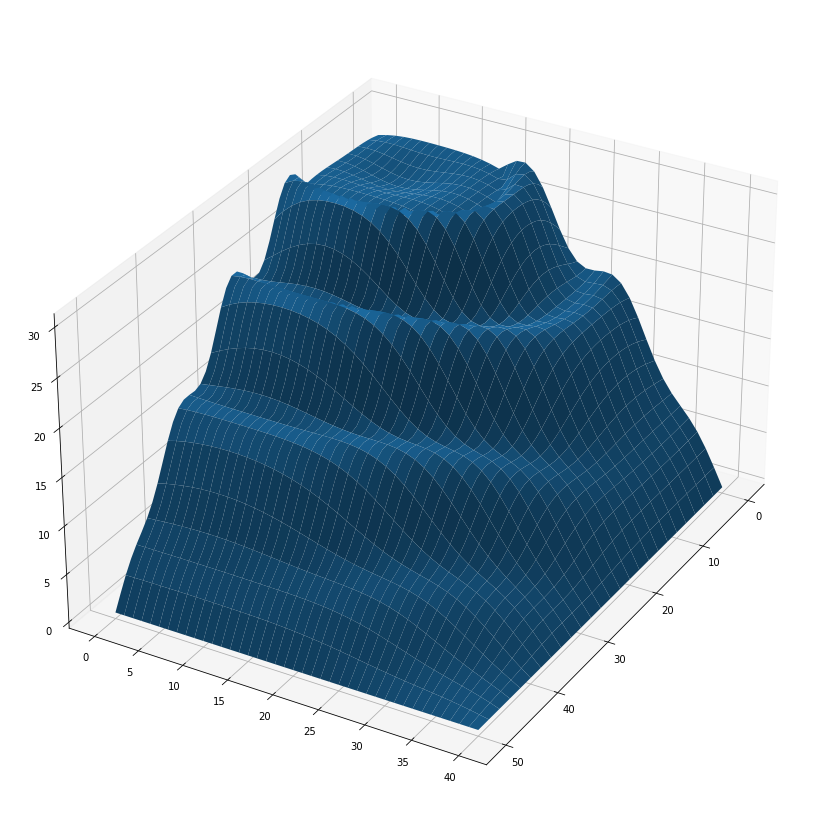

In [3]:
x = range(width+1)
y = range(length+1)
z = np.zeros((length+1,width+1))
for x_val in x:
    for y_val in y:
        z[y_val,x_val]=height(x_val,y_val)
        
x, y = np.meshgrid(x, y)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

ax.plot_surface(x, y, z)
ax.view_init(elev=30, azim=30)
ax.set_box_aspect((width, length, height_m))

# Preparing the Profiles

In [4]:
nb_slice_x = int(length/dy) 
delta_y = (length - (nb_slice_x-1)*dy)/2

if   delta_y<dy/4:
    nb_slice_x=nb_slice_x-1
    delta_y = (length - (nb_slice_x-1)*dy)/2
    print('remove 1 y')
    
nb_slice_fb = int(width/step)
delta_x = (width - (nb_slice_fb-0.5)*step)/2
if  delta_x<step/4:
    nb_slice_fb=nb_slice_fb-1
    delta_x = (width - (nb_slice_fb-0.5)*step)/2
    print('remove 1 x')
               
nb_slice_fb_l = int(nb_slice_x/2)

In [5]:
print(f'delta_x = {delta_x} nb fb = {nb_slice_fb} , delta_y = {delta_y}  nb x = {nb_slice_x}, step {step}, dy {dy}')

delta_x = 1.25 nb fb = 10 , delta_y = 2.679491924311229  nb x = 9, step 5, dy 4.330127018922193


intersections

In [6]:
intersections = {}
slice_inter_x = {}
slice_inter_f = {}
slice_inter_b = {}

counter = 1
for y_index in range(nb_slice_fb_l+nb_slice_fb+nb_slice_x):
    f_index = y_index-nb_slice_fb_l
    for x_index in range(nb_slice_x):
        b_index = y_index - x_index
        int_x = delta_x  + step*f_index - x_index * step/2
        int_y = delta_y + x_index * dy
        
        if int_x>0 and int_x<width:
            intersections[counter] = [int_x,int_y]
            if x_index not in slice_inter_x.keys():
                slice_inter_x[x_index]=[]
            slice_inter_x[x_index].append(counter)
            if f_index not in slice_inter_f.keys():
                slice_inter_f[f_index]=[]
            slice_inter_f[f_index].append(counter)
            if b_index not in slice_inter_b.keys():
                slice_inter_b[b_index]=[]
            slice_inter_b[b_index].append(counter)
            counter = counter + 1
    

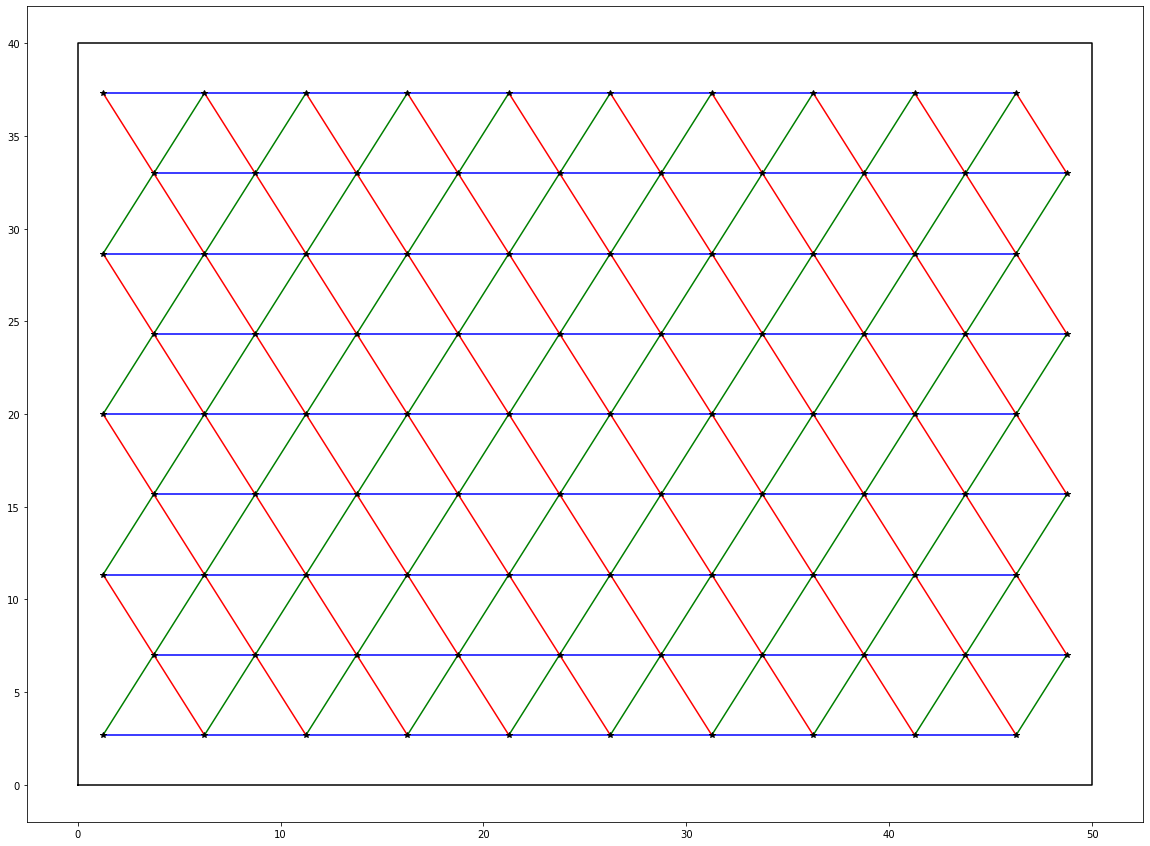

In [7]:


for key_x in slice_inter_x.keys():
    x_int_x = [intersections[ind][0] for ind in slice_inter_x[key_x]]
    x_int_y = [intersections[ind][1] for ind in slice_inter_x[key_x]]
    plt.plot(x_int_x,x_int_y,'-b')
    
for key_f in slice_inter_f.keys():
    f_int_x = [intersections[ind][0] for ind in slice_inter_f[key_f]]
    f_int_y = [intersections[ind][1] for ind in slice_inter_f[key_f]]
    plt.plot(f_int_x,f_int_y,'-r')
    
for key_b in slice_inter_b.keys():
    b_int_x = [intersections[ind][0] for ind in slice_inter_b[key_b]]
    b_int_y = [intersections[ind][1] for ind in slice_inter_b[key_b]]
    plt.plot(b_int_x,b_int_y,'-g')
    
plt.plot([0,width,width,0,0],[0,0,length,length,0],'-k')
    
all_x = [intersections[key][0] for key in intersections.keys()]
all_y = [intersections[key][1] for key in intersections.keys()]
plt.plot(all_x,all_y,'*k')

In [8]:
def get_sampling(x_0,y_0,x_1,y_1,gap_0,gap_1,samp):
    L = np.sqrt((x_1-x_0)*(x_1-x_0)+(y_1-y_0)*(y_1-y_0))
    nb_sample_total = int(L/samp)
    nb_sample_util = int((L - gap_0 - gap_1)/samp)
    
    x_s = [x_0 +(x_1-x_0)*(index+gap_0/samp)/nb_sample_total for index in range(nb_sample_util)] 
    y_s = [y_0 +(y_1-y_0)*(index+gap_0/samp)/nb_sample_total for index in range(nb_sample_util)] 
    l_s = [(index*samp + gap_0) for index in range(nb_sample_util)]
    
    return x_s, y_s, l_s 

Text(0.5, 1.0, 'Slices parallel to the long side')

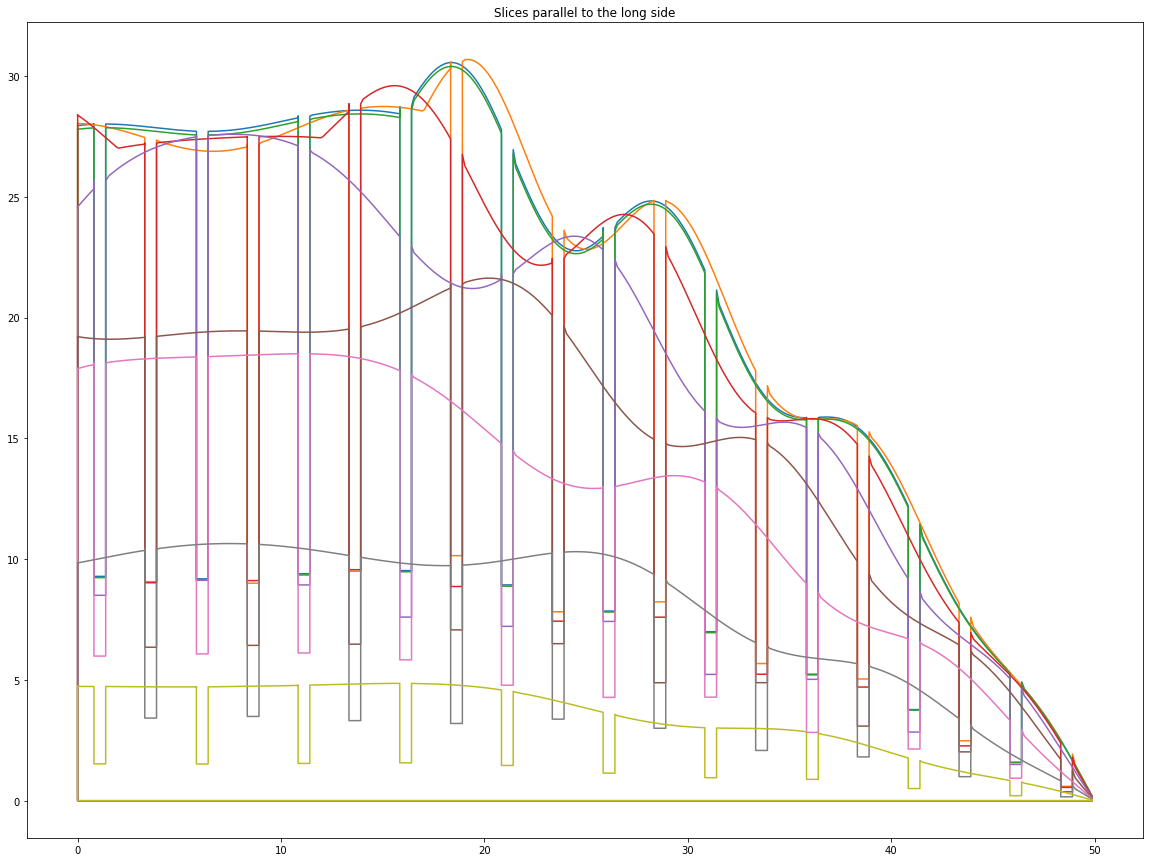

In [9]:
profile_x = {}

for key_x in slice_inter_x.keys():
    ls=[]
    vs=[]
    cur_h=0
    max_h=width
    cur_x = 0
    cur_y = intersections[slice_inter_x[key_x][0]][1]
    begin_x = cur_x
    begin_y = cur_y
    
    next_x = intersections[slice_inter_x[key_x][0]][0]
    next_y =  intersections[slice_inter_x[key_x][0]][1]
    
    # first part
    x_s,y_s, l_s = get_sampling(cur_x,cur_y,next_x,next_y, 0, g_h, dim_maille)
    h_s = []
    
    for index in range(len(x_s)):
        h_s.append(height(x_s[index],y_s[index]))
    ls=ls+l_s
    vs=vs+h_s
    
    #intersections 
    for index in range(len(slice_inter_x[key_x])):
        cur_x = next_x
        cur_y = next_y
        gap_1 = g_h
        h_top = height(cur_x,cur_y)
        h_bottom = height_b(cur_x,cur_y)
        
        h_cut = (h_top-h_bottom)/3 + h_bottom - additional_gap/2
        ls_cut = [ls[-1],ls[-1],ls[-1]+2*g_h,ls[-1]+2*g_h]
        hs_cut = [h_top,h_cut,h_cut,h_top]
        ls=ls+ls_cut
        vs=vs+hs_cut
        
   
        if index<len(slice_inter_x[key_x])-1:
            next_x = intersections[slice_inter_x[key_x][index+1]][0]
            next_y =  intersections[slice_inter_x[key_x][index+1]][1]
        else:
            next_x = width
            next_y =  intersections[slice_inter_x[key_x][-1]][1]
            gap_1 = 0
        x_s,y_s, l_s = get_sampling(cur_x,cur_y,next_x,next_y, g_h, gap_1, dim_maille)
        h_s = []
        for index in range(len(x_s)):
            h_s.append(height(x_s[index],y_s[index]))
        ls=ls+x_s
        vs=vs+h_s    
    # back
    ls.append(ls[-1])
    vs.append(height_b(next_x,next_y))
    for index in range(len(slice_inter_x[key_x])):
        curr_index = len(slice_inter_x[key_x])-1-index
        cur_x = next_x
        cur_y = next_y
        next_x = intersections[slice_inter_x[key_x][curr_index]][0]
        next_y = intersections[slice_inter_x[key_x][curr_index]][1]
        ls.append(np.sqrt((begin_x-next_x)*(begin_x-next_x)+(begin_y-next_y)*(begin_y-next_y)))
        vs.append(height_b(next_x,next_y))
    ls.append(0)
    vs.append(height_b(begin_x,begin_y))
    ls.append(0)
    vs.append(height(begin_x,begin_y))
    
    profile_x[key_x]=[ls,vs]
    plt.plot(ls,vs,'-')
plt.title('Slices parallel to the long side')
 

    


Text(0.5, 1.0, 'Slices at +60°')

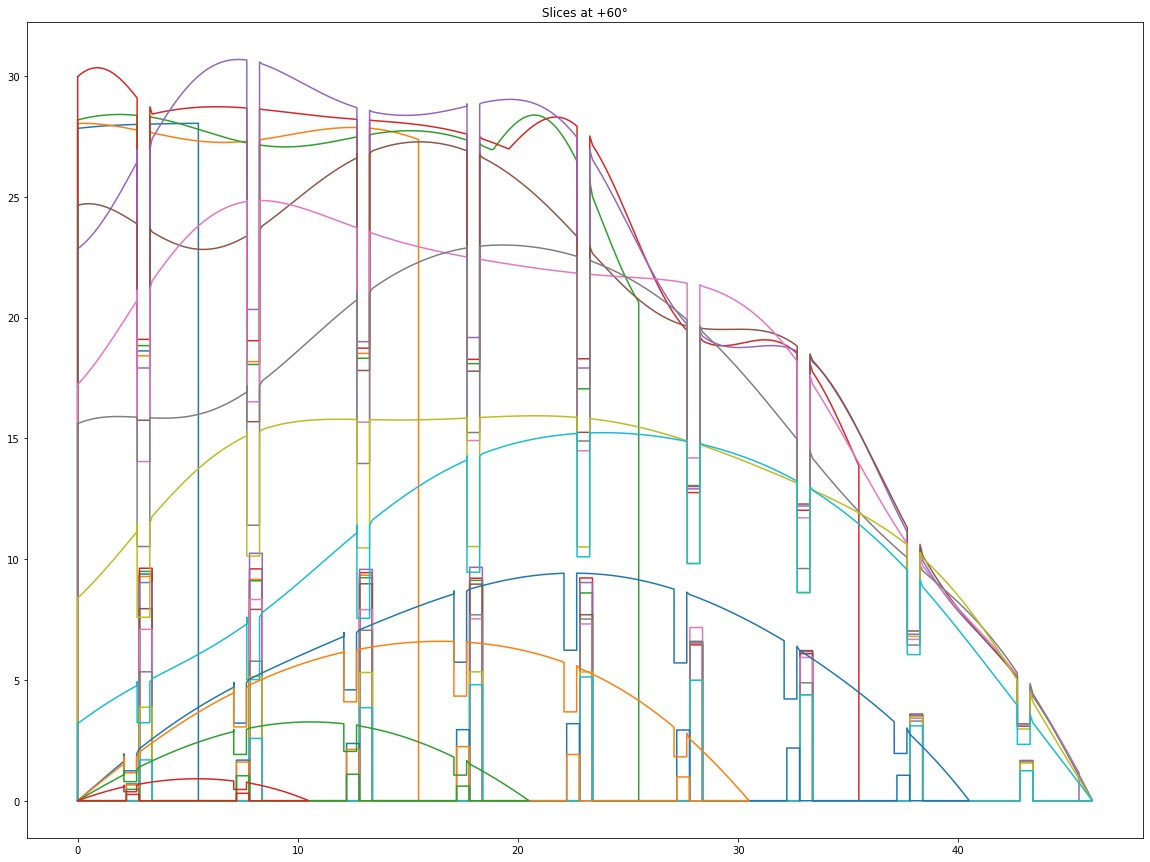

In [10]:
profile_f = {}

for key_f in slice_inter_f.keys():
    ls=[]
    vs=[]
    cur_h=0
    max_h=width
    cur_x = intersections[slice_inter_f[key_f][0]][0] + intersections[slice_inter_f[key_f][0]][1] /np.tan(60*np.pi/180)
    cur_y = 0
    
    if cur_x>width:
        cur_y = (cur_x-width)*np.tan(60*np.pi/180) 
        cur_x = width
    
    begin_x = cur_x
    begin_y = cur_y
    
    next_x = intersections[slice_inter_f[key_f][0]][0]
    next_y =  intersections[slice_inter_f[key_f][0]][1]
    
    # first part
    x_s,y_s, l_s = get_sampling(cur_x,cur_y,next_x,next_y, 0, g_h, dim_maille)
    h_s = []
    
    for index in range(len(x_s)):
        h_s.append(height(x_s[index],y_s[index]))
    ls=ls+l_s
    vs=vs+h_s
    
    #intersections 
    for index in range(len(slice_inter_f[key_f])):
        cur_x = next_x
        cur_y = next_y
        gap_1 = g_h
        h_top = height(cur_x,cur_y)
        h_bottom = height_b(cur_x,cur_y)
        
        h_cut = 2*(h_top-h_bottom)/3 + h_bottom - additional_gap/2
        ls_cut = [ls[-1],ls[-1],ls[-1]+2*g_h,ls[-1]+2*g_h]
        hs_cut = [h_top,h_cut,h_cut,h_top]
        ls=ls+ls_cut
        vs=vs+hs_cut
        
   
        if index<len(slice_inter_f[key_f])-1:
            next_x = intersections[slice_inter_f[key_f][index+1]][0]
            next_y =  intersections[slice_inter_f[key_f][index+1]][1]
        else:
            x_1 = cur_x - (length-cur_y)/np.tan(60*np.pi/180) 
            if x_1>=0:
                next_x = x_1
                next_y = length
            else:
                next_x = 0
                next_y = cur_y + cur_x * np.tan(60*np.pi/180) 
            gap_1 = 0
        x_s,y_s, l_s = get_sampling(cur_x,cur_y,next_x,next_y, g_h, gap_1, dim_maille)
        h_s = []
        for index in range(len(x_s)):
            h_s.append(height(x_s[index],y_s[index]))
        l = np.sqrt((begin_x-cur_x)*(begin_x-cur_x)+(begin_y-cur_y)*(begin_y-cur_y))
        ls=ls+[l_+l for l_ in l_s]
        vs=vs+h_s  
    
    # back
    
    ls.append(ls[-1])
    vs.append(height_b(next_x,next_y))
    for index in range(len(slice_inter_f[key_f])):
        curr_index = len(slice_inter_f[key_f])-1-index
        cur_x = next_x
        cur_y = next_y
        next_x = intersections[slice_inter_f[key_f][curr_index]][0]
        next_y = intersections[slice_inter_f[key_f][curr_index]][1]
        l = np.sqrt((begin_x-next_x)*(begin_x-next_x)+(begin_y-next_y)*(begin_y-next_y))
        ls = ls +[l+g_h,l+g_h,l-g_h,l-g_h]
        h_top = height(next_x,next_y)
        h_bottom = height_b(next_x,next_y)
        
        vs = vs + [h_bottom,(h_top-h_bottom)/3 + h_bottom + additional_gap/2, (h_top-h_bottom)/3 + h_bottom + additional_gap/2, h_bottom]

    ls.append(0)
    vs.append(height_b(begin_x,begin_y))
    ls.append(0)
    vs.append(height(begin_x,begin_y))
    
    profile_f[key_f]=[ls,vs]
    plt.plot(ls,vs,'-')

plt.title('Slices at +60°')
    
 

Text(0.5, 1.0, 'Slices at -60°')

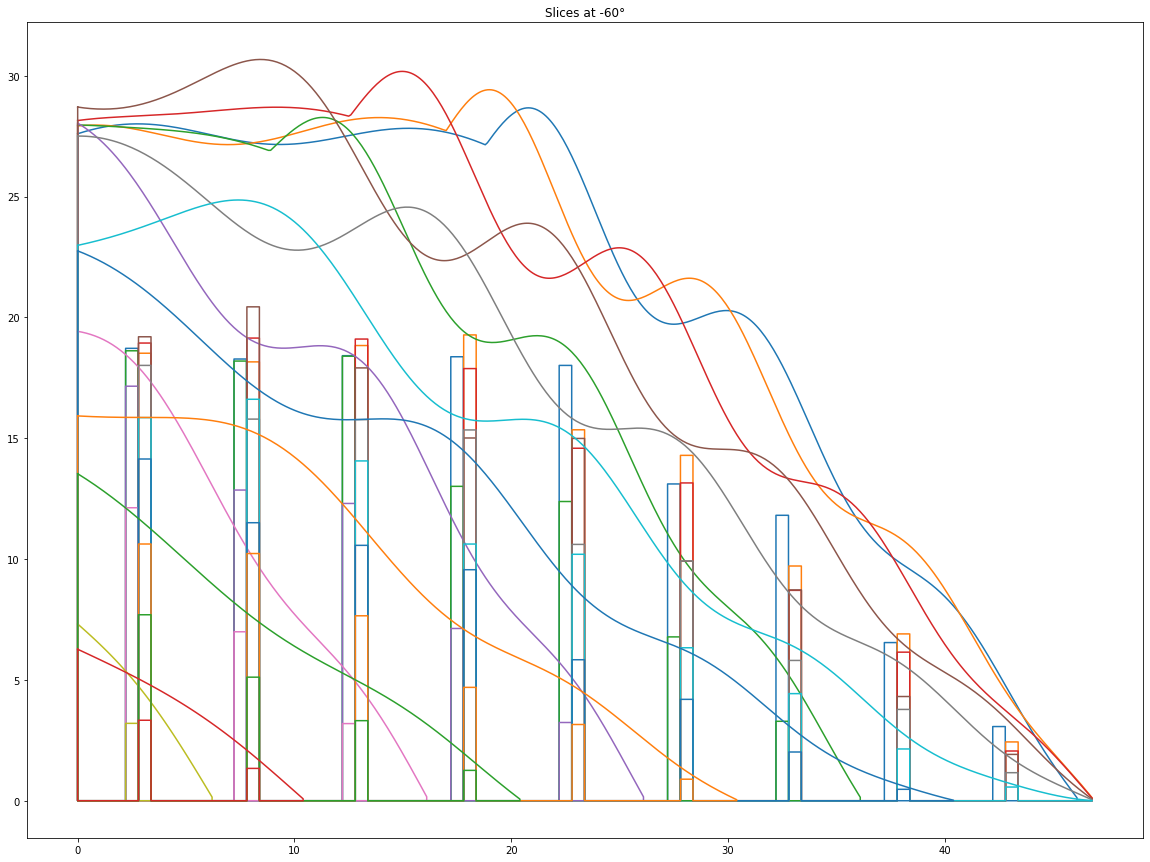

In [11]:
profile_b = {}

for key_b in slice_inter_b.keys():
    ls=[]
    vs=[]
    cur_h=0
    max_h=width
    cur_x = intersections[slice_inter_b[key_b][0]][0] - intersections[slice_inter_b[key_b][0]][1] /np.tan(60*np.pi/180)
    cur_y = 0
    
    if cur_x<0:
        cur_y = (-cur_x)*np.tan(60*np.pi/180) 
        cur_x = 0
        
    
    begin_x = cur_x
    begin_y = cur_y
    
    i_x = intersections[slice_inter_b[key_b][0]][0]
    i_y = intersections[slice_inter_b[key_b][0]][1]
    
    x_1 = i_x + (length-cur_y)/np.tan(60*np.pi/180) 
    if x_1<=width:
        next_x = x_1
        next_y = length
    else:
        next_x = width
        next_y = i_y + (width-i_x) * np.tan(60*np.pi/180) 


    # first part
    x_s,y_s, l_s = get_sampling(cur_x,cur_y,next_x,next_y, 0, 0, dim_maille)
    h_s = []
    
    for index in range(len(x_s)):
        h_s.append(height(x_s[index],y_s[index]))
    ls=ls+l_s
    vs=vs+h_s
    
   
    # back
    
    ls.append(ls[-1])
    vs.append(height_b(next_x,next_y))
    for index in range(len(slice_inter_b[key_b])):
        curr_index = len(slice_inter_b[key_b])-1-index
        cur_x = next_x
        cur_y = next_y
        next_x = intersections[slice_inter_b[key_b][curr_index]][0]
        next_y = intersections[slice_inter_b[key_b][curr_index]][1]
        l = np.sqrt((begin_x-next_x)*(begin_x-next_x)+(begin_y-next_y)*(begin_y-next_y))
        ls = ls +[l+g_h,l+g_h,l-g_h,l-g_h]
        h_top = height(next_x,next_y)
        h_bottom = height_b(next_x,next_y)
        
        vs = vs + [h_bottom,2*(h_top-h_bottom)/3 + h_bottom + additional_gap/2, 2*(h_top-h_bottom)/3 + h_bottom + additional_gap/2, h_bottom]

    ls.append(0)
    vs.append(height_b(begin_x,begin_y))
    ls.append(0)
    vs.append(height(begin_x,begin_y))
    
    profile_b[key_b]=[ls,vs]
    plt.plot(ls,vs,'-')
    
plt.title('Slices at -60°')

In [12]:
def make_svg(profiles, intersections, slice_inter, step,  name):
    gap=1
    number = len(profiles)
    max_x=[]
    max_y=[]
    for key in profiles.keys():
        max_x.append(np.max(np.array(profiles[key][0])))
        max_y.append(np.max(np.array(profiles[key][1])))
    
    #color=[f'#'+str(hex(int(k*256/number)))[2:] +str(hex(255-int(k*256/number)))[2:]+'00' for k in range(number)]

    svg = ''
    
    index =0
    position = 0
    delt =0.5
   
    for key in profiles.keys():
        if (name=='X'):
            delt=(index%2)/2
        position+=max_y[index]+gap
        point_x=profiles[key][0]
        point_y=profiles[key][1]
        
        pol_points=''
        for idx in range(len(point_x)):
            pol_points = pol_points+ f'{point_x[idx]},{position-point_y[idx]} '
        svg = svg + f'<polygon points="{pol_points}" style="fill:none;stroke:black;stroke-width:0.1" />\n'
        
        svg = svg + f'<polygon points="0,{position} {width},{position}" style="fill:none;stroke:blue;stroke-width:0.1" />\n'
        
        svg = svg + f'<text x="0.2" y="{position-0.2}" class="small" >{name}-{index}</text>'
        idx=0
        for inter in slice_inter[key]:
            
            svg = svg + f'<text x="{step*(idx+delt)+3*g_h}" y="{position - 0.2}" class="tiny" >i-{inter}</text>'
            idx+=1
        
        
        index = index +1 
    svg = '<g transform="scale(35.43307)">\n' + svg + '</g>\n'
    svg = f'<svg height="{position}cm" width="{np.max([np.max(max_x),width])}cm" xmlns="http://www.w3.org/2000/svg">\n'+ \
    '<style>\n.small {font: 1px sans-serif;fill:red;}\n.tiny {font: 0.5px sans-serif;fill:red;}</style>\n' +svg + '</svg>'
    return svg
   

In [13]:
print('Parallel')
with open('profile_x.svg', 'w') as f:
    f.write(make_svg(profile_x, intersections, slice_inter_x, step, 'X'))
print('+60°')
with open('profile_f.svg', 'w') as f:
    f.write(make_svg(profile_f, intersections, slice_inter_f, step, 'F'))   
print('-60°') 
with open('profile_b.svg', 'w') as f:
    f.write(make_svg(profile_b, intersections, slice_inter_b, step, 'B'))    

Parallel
+60°
-60°
